<a href="https://colab.research.google.com/github/lokesharma-dev/Fake-News-Detection/blob/master/VAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional

### Load and split dataset

In [0]:
data = np.load('/content/npy/data.npy',allow_pickle=True)
label = np.load('/content/npy/label.npy',allow_pickle=True)
num_test_samples = int(0.2 * data.shape[0])
x_train = data[:-num_test_samples]
y_train = data[:-num_test_samples]
x_test = data[-num_test_samples:]
y_test = data[-num_test_samples:]

### Hyperparameters

In [0]:
max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 200
batch_size = 128
epochs=10
alpha=0.50
ratio =0.5
lr= 0.0005
vocab_size = 1000

### Custom Functions

In [0]:
def compute_kld(p_logit, q_logit):
  p = tf.nn.softmax(p_logit)
  q = tf.nn.softmax(q_logit)
  # kl_score = tf.reduce_sum(tf.where(condition=(p==0), x=tf.zeros(p.shape, tf.float64),y = p * tf.log(p/q)))
  kl_score = tf.reduce_sum( p * (tf.math.log(p+1e-16) - tf.math.log(q+1e-16)), axis = 1)
  return kl_score # lower kl means closer the distributions are
# Plot p | q | kl
# make sure p is not zero

def make_unit_norm(x):
  x_norm = x/(tf.reshape(tf.sqrt(tf.reduce_sum(tf.pow(x,2), axis=1)), [-1,1]) + 1e-16)
  return x_norm

In [62]:
def biLstmModel(maxlen, vocab_size):
  inputs = tf.keras.Input(shape=(maxlen,))
  emb = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
  layer1 = Bidirectional(LSTM(units=128, return_sequences=False))(emb)
  layer2 = Dense(units=2, activation='sigmoid')(layer1)
  output_layer = Dense(units=1)(layer2)
  model = Model(inputs, output_layer)
  return model

model = biLstmModel(maxlen, vocab_size)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 200, 128)          128000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 514       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 3         
Total params: 391,685
Trainable params: 391,685
Non-trainable params: 0
_________________________________________________________________


### Model

In [0]:
inputs = Input(shape=(maxlen,))
model_vat = Sequential()
model_vat.add(Embedding(input_dim=vocab_size, output_dim=128))
p_logit = model_vat(inputs)
layer1 = Bidirectional(LSTM(units=128))(p_logit)
layer2 = Dense(units=2, activation='sigmoid')(layer1)
output_layer = Dense(units=1)(layer2)

# Noise
r = tf.random.uniform(shape=tf.shape(inputs))
r = make_unit_norm(r) # will have the shape of your input
p_logit_r = model_vat(inputs + 10*r) # Perturbations added just after Embedding layer

In [0]:
with tf.GradientTape() as tape:
  kl_score = tf.reduce_mean(compute_kld(p_logit, p_logit_r))

grads = tape.gradient(kl_score, [r])
grads = [grad if grad is not None else tf.zeros_like(r)for r, grad in zip([r], grads)]
grad_kl = grads[0]
r_vadv = tf.stop_gradient(grad_kl)
r_vadv = make_unit_norm(r_vadv)/3

p_logit_no_gradient = tf.stop_gradient(p_logit)
p_logit_r_adv = model_vat( inputs  + r_vadv)
vat_loss =  tf.reduce_mean(compute_kld( p_logit_no_gradient, p_logit_r_adv ))

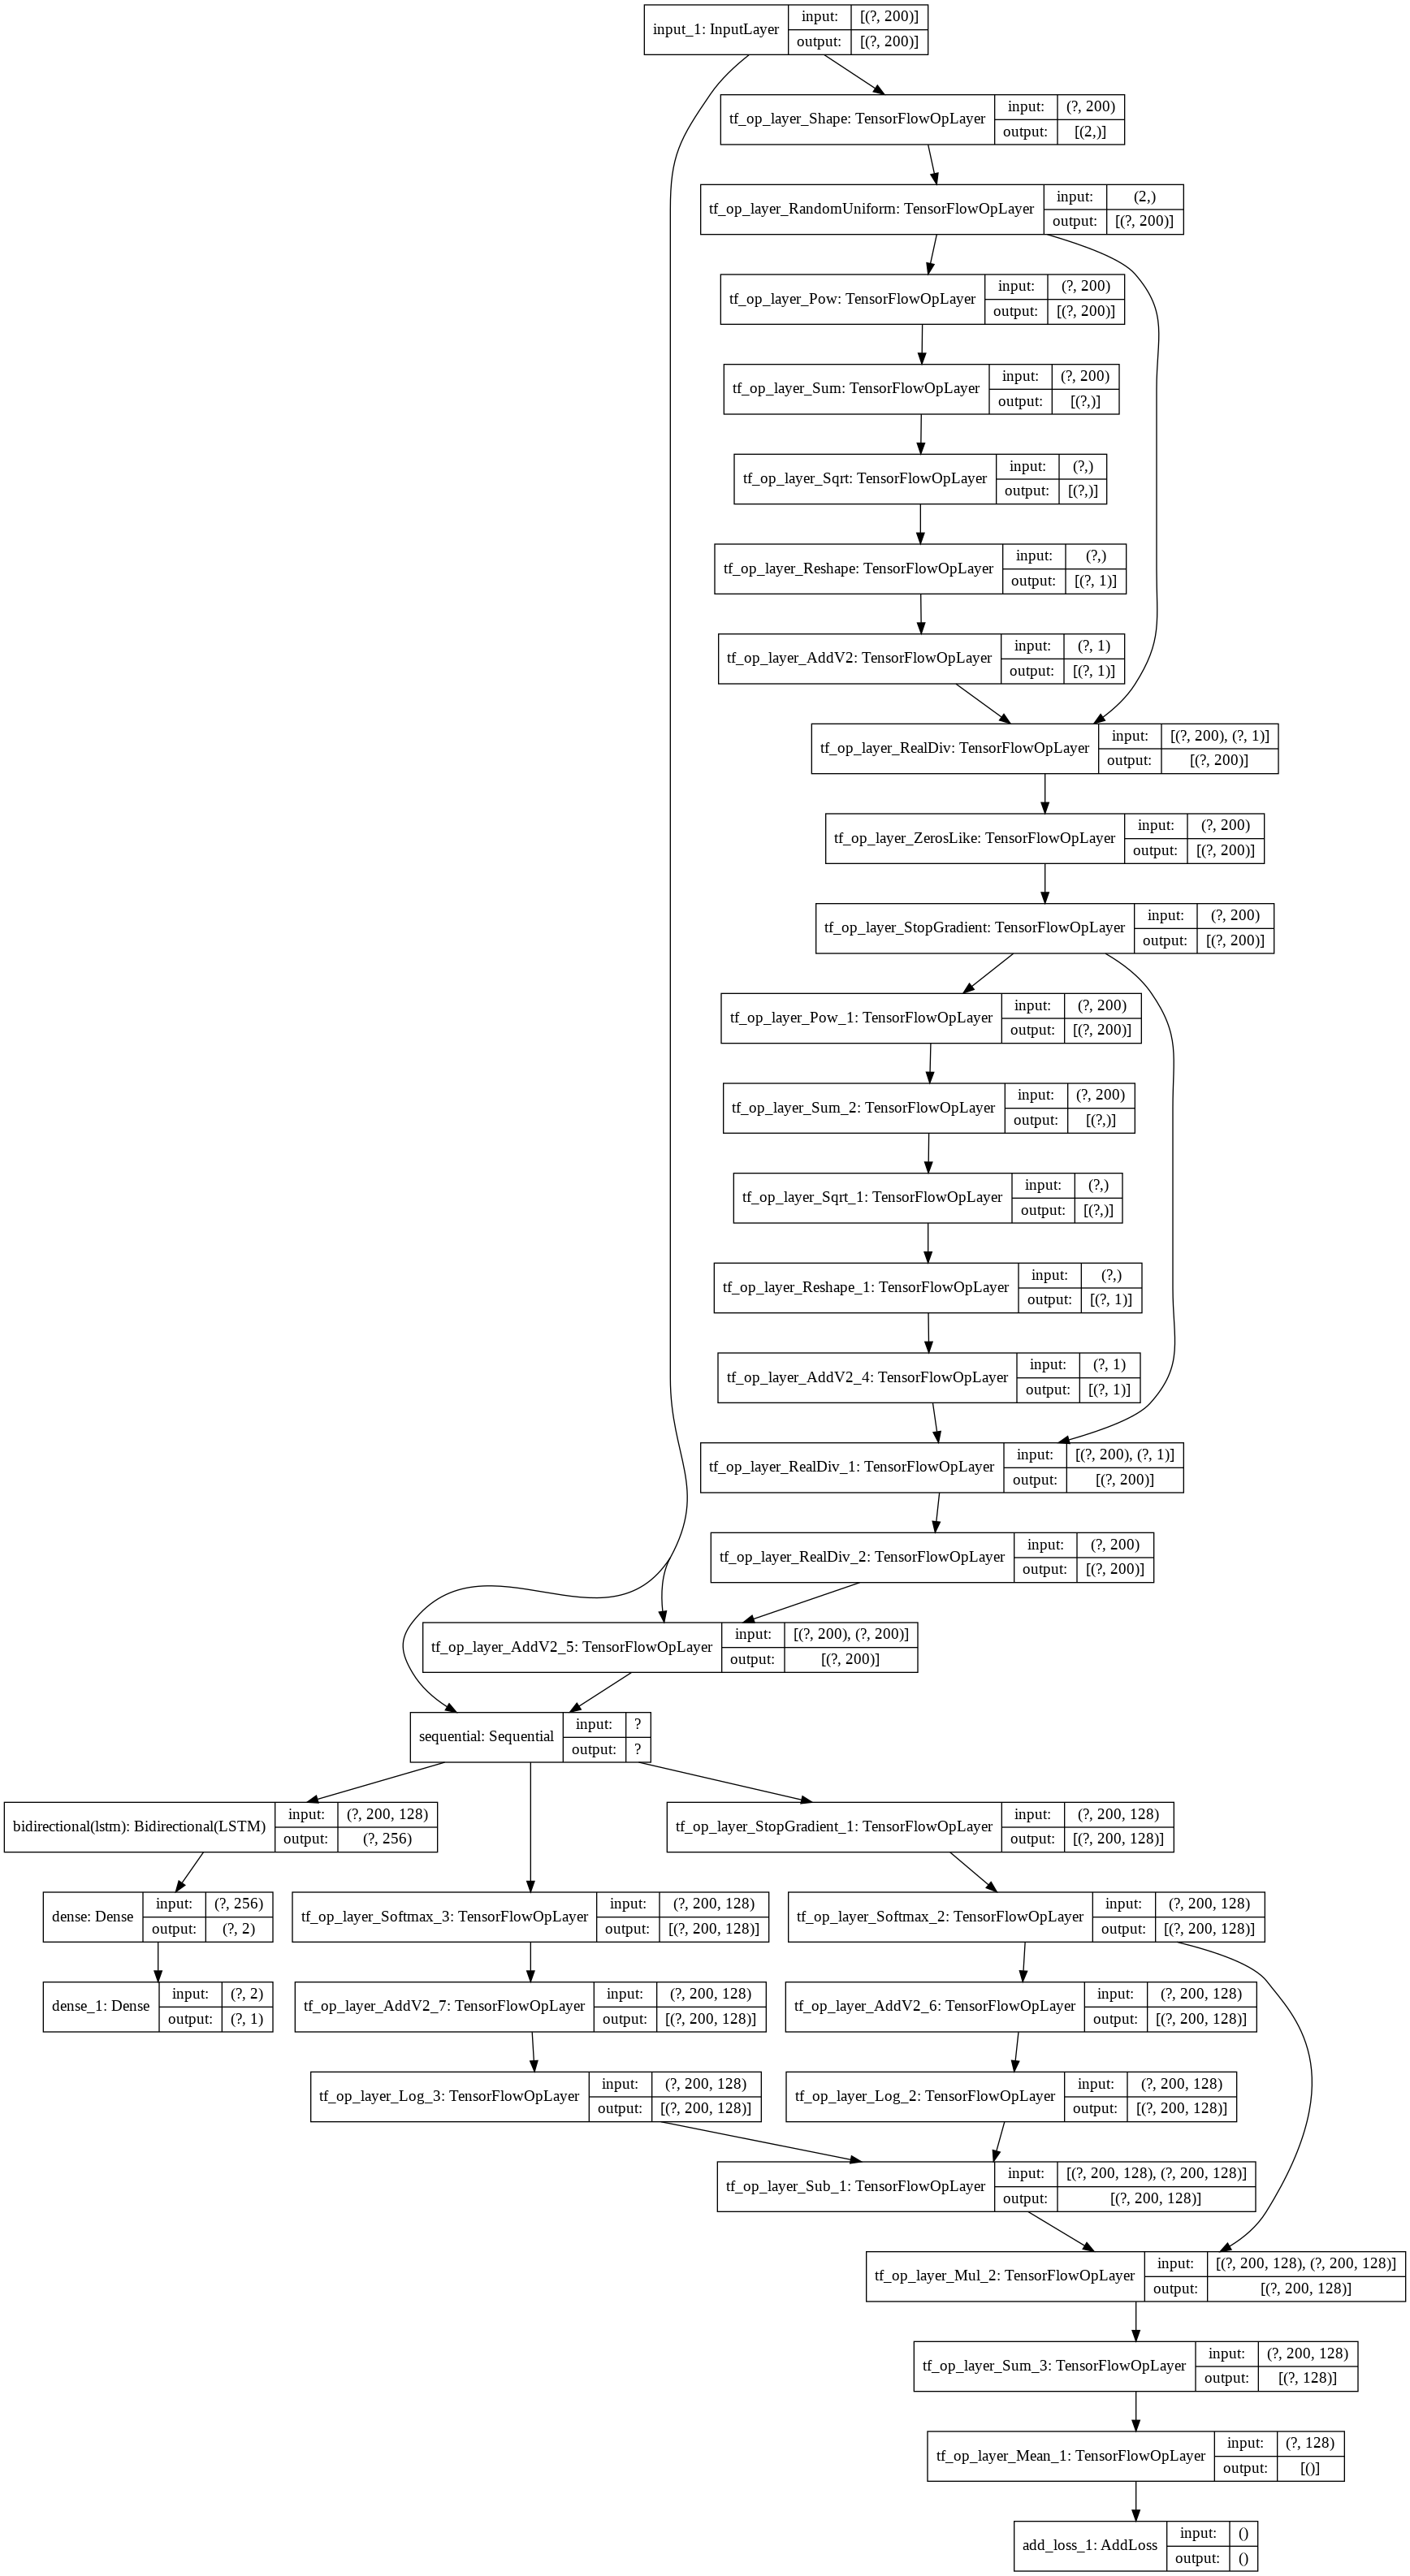

In [112]:
model_vat = Model(inputs , output_layer )
model_vat.add_loss(vat_loss )

model_vat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss= 'binary_crossentropy',metrics=['accuracy'])

model_vat.metrics_names.append('vat_loss')
model_vat.metrics.append(vat_loss)

tf.keras.utils.plot_model(model_vat, show_shapes=True, show_layer_names=True )


In [107]:
r_vadv.shape

TensorShape([None, 200])

In [69]:
print('Inputs shape', np.shape(inputs))
print("Embedding shape", np.shape(emb))
print("Layer1 shape", np.shape(layer1))
print("Layer2 shape", np.shape(layer2))
print("Output Layer shape", np.shape(output_layer))

Inputs shape (None, 200)
Embedding shape (None, 200, 128)
Layer1 shape (None, 256)
Layer2 shape (None, 2)
Output Layer shape (None, 1)
